# 02 — Test & Demo (Images + Videos)

This notebook:
1. Downloads **test_data.zip** from Google Drive → unzips to `soccer_vision/test_data/`.
2. Downloads **yolo11s.zip** from Google Drive → unzips to `soccer_vision/models/yolo11s/`.
3. Runs inference on:
   - `test_data/images/` (all images)
   - `test_data/videos/` (all videos)
4. Shows a small preview grid for a few predicted images.

> Works whether you launch the notebook from `footbot/` or `soccer_vision/`.  
> All artifacts are kept inside `soccer_vision/`.


In [1]:
import os, sys, zipfile, shutil
from pathlib import Path

# 3rd-party
try:
    import gdown  # Google Drive downloader
except Exception:
    %pip -q install gdown
    import gdown

# Our modules
from notebooks.modules.paths import base_paths, find_repo_root
from notebooks.modules.logging_utils import get_logger, log
from notebooks.modules.data_utils import ensure_dir


In [2]:
# === CONFIG (edit these) ===
# Google Drive file IDs: take the 'id=...' from your share links
TESTDATA_FILE_ID = "10BGZnxr_Eyb4RpH8UnXCkrTXSXciv5kq"
YOLO11S_FILE_ID  = "1UUnKGgA8MoC039voS9hZmL8M1BV8Kh51"

# Inference settings
CONF_THRESH = 0.25  # detection confidence for demos

In [3]:
# Use the same root resolution as training
BASE = find_repo_root()
PATHS = base_paths(BASE)
BASE, DATASET, MODELS, RUNS, DATA_YAML = PATHS["BASE"], PATHS["DATASET"], PATHS["MODELS"], PATHS["RUNS"], PATHS["DATA_YAML"]

print("[BASE]", BASE)
print("[MODELS]", MODELS)
print("[RUNS]", RUNS)

[BASE] Z:\Proyectos\Robotica\footbot\soccer_vision
[MODELS] Z:\Proyectos\Robotica\footbot\soccer_vision\models
[RUNS] Z:\Proyectos\Robotica\footbot\soccer_vision\runs


In [4]:
def gdown_by_id(file_id: str, out_path: Path) -> bool:
    url = f"https://drive.google.com/uc?id={file_id}"
    log.info("[DL] %s -> %s", url, out_path)
    ensure_dir(out_path.parent)
    return bool(gdown.download(url, str(out_path), quiet=False))

def unzip_to(zip_path: Path, dest_dir: Path):
    log.info("[UNZIP] %s -> %s", zip_path.name, dest_dir)
    ensure_dir(dest_dir)
    with zipfile.ZipFile(zip_path, "r") as z:
        z.extractall(dest_dir)

def tree(path: Path, max_files=8):
    print(f"\n[Tree] {path.resolve()}")
    for root, dirs, files in os.walk(path):
        rel = Path(root).relative_to(path)
        indent = "  " * len(rel.parts)
        print(f"{indent}{Path(root).name}/")
        for d in sorted(dirs):
            print(f"{indent}  {d}/")
        files = sorted(files)
        for i, f in enumerate(files[:max_files]):
            print(f"{indent}  {f}")
        if len(files) > max_files:
            print(f"{indent}  ... (+{len(files)-max_files} more)")

def looks_like_testdata(ds: Path) -> bool:
    return (ds / "images").exists() or (ds / "videos").exists()

## 1) Download & unpack `test_data.zip`

- Unpacked to: `soccer_vision/test_data/`
- Must contain `images/` and/or `videos/` subfolders.


In [5]:
TESTDATA_DIR  = BASE / "test_data"
TESTDATA_ZIP  = BASE / "test_data.zip"
TMP_TESTDATA  = BASE / "_tmp_unzip_testdata"

if TESTDATA_DIR.exists() and looks_like_testdata(TESTDATA_DIR):
    log.info("[INFO] test_data/ already exists, skipping download.")
else:
    if not TESTDATA_FILE_ID or TESTDATA_FILE_ID.startswith("REPLACE_"):
        raise SystemExit("[ERR] Please set TESTDATA_FILE_ID in the Config cell.")

    ok = gdown_by_id(TESTDATA_FILE_ID, TESTDATA_ZIP)
    if not ok:
        raise SystemExit("[ERR] gdown failed. Ensure the Drive file is public (Anyone with the link).")

    # Unzip into a temp folder to avoid clutter
    if TMP_TESTDATA.exists():
        shutil.rmtree(TMP_TESTDATA)
    unzip_to(TESTDATA_ZIP, TMP_TESTDATA)

    # Find a folder inside temp that contains images/ or videos/
    candidates = [p for p in TMP_TESTDATA.rglob("*") if p.is_dir() and looks_like_testdata(p)]
    if not candidates:
        raise SystemExit("[ERR] Could not find a folder with images/ or videos/ after unzip.")
    pick = next((c for c in candidates if c.name == "test_data"), candidates[0])

    # Move to the canonical location BASE/test_data
    if TESTDATA_DIR.exists():
        shutil.rmtree(TESTDATA_DIR)
    shutil.move(str(pick), str(TESTDATA_DIR))

    # Clean up
    log.info("[CLEAN] Removing temp + zip")
    shutil.rmtree(TMP_TESTDATA, ignore_errors=True)
    try:
        TESTDATA_ZIP.unlink()
    except FileNotFoundError:
        pass

print("[OK] test_data ready at:", TESTDATA_DIR)
tree(TESTDATA_DIR)


[INFO] [INFO] test_data/ already exists, skipping download.
[OK] test_data ready at: Z:\Proyectos\Robotica\footbot\soccer_vision\test_data

[Tree] Z:\Proyectos\Robotica\footbot\soccer_vision\test_data
test_data/
  images/
  videos/
  images/
    robot.jpeg
  videos/
    automatic_robot.mp4


## 2) Download & unpack `yolo11s.zip` (model)

- Target model path (required): `soccer_vision/models/yolo11s/soccer_yolo.pt`
- If the zip unpacks differently, we normalize and move things into the right place.


In [6]:
TARGET_DIR      = MODELS / "yolo11s"
TARGET_WEIGHTS  = TARGET_DIR / "soccer_yolo.pt"
MODEL_ZIP       = BASE / "yolo11s.zip"
TMP_MODEL_UNZIP = BASE / "_tmp_unzip_model"

if TARGET_WEIGHTS.exists():
    log.info("[INFO] Model already present: %s", TARGET_WEIGHTS)
else:
    if not YOLO11S_FILE_ID:
        raise SystemExit("[ERR] Please set YOLO11S_FILE_ID in the Config cell.")
    ok = gdown_by_id(YOLO11S_FILE_ID, MODEL_ZIP)
    if not ok:
        raise SystemExit("[ERR] gdown failed. Ensure the Drive file is public (Anyone with the link).")

    # Extract into a temp folder
    if TMP_MODEL_UNZIP.exists():
        shutil.rmtree(TMP_MODEL_UNZIP)
    unzip_to(MODEL_ZIP, TMP_MODEL_UNZIP)

    # Locate soccer_yolo.pt inside the temp folder
    found = None
    for p in TMP_MODEL_UNZIP.rglob("soccer_yolo.pt"):
        found = p
        break
    if not found:
        raise SystemExit("[ERR] Could not find 'soccer_yolo.pt' after unzipping yolo11s.zip")

    # The parent folder of the weights becomes our final TARGET_DIR
    src_dir = found.parent
    if TARGET_DIR.exists():
        shutil.rmtree(TARGET_DIR)
    ensure_dir(TARGET_DIR.parent)
    shutil.move(str(src_dir), str(TARGET_DIR))

    # Clean temp + zip
    log.info("[CLEAN] Removing temp + zip")
    shutil.rmtree(TMP_MODEL_UNZIP, ignore_errors=True)
    try:
        MODEL_ZIP.unlink()
    except FileNotFoundError:
        pass

print("[OK] Model ready at:", TARGET_WEIGHTS)
tree(TARGET_DIR)


[INFO] [INFO] Model already present: Z:\Proyectos\Robotica\footbot\soccer_vision\models\yolo11s\soccer_yolo.pt
[OK] Model ready at: Z:\Proyectos\Robotica\footbot\soccer_vision\models\yolo11s\soccer_yolo.pt

[Tree] Z:\Proyectos\Robotica\footbot\soccer_vision\models\yolo11s
yolo11s/
  train_artifacts/
  soccer_yolo.pt
  train_artifacts/
    weights/
    F1_curve.png
    PR_curve.png
    P_curve.png
    R_curve.png
    args.yaml
    confusion_matrix.png
    confusion_matrix_normalized.png
    labels.jpg
    ... (+13 more)
    weights/
      best.pt
      last.pt


In [7]:
try:
    import ultralytics  # noqa: F401
    import torch        # noqa: F401
except Exception:
    %pip -q install ultralytics torch
    import ultralytics, torch

import ultralytics, torch
os.environ.setdefault("ULTRALYTICS_HOME", str(BASE))  # keep runs/cache inside repo

device = 0 if torch.cuda.is_available() else "cpu"
print("Python:", sys.executable)
print("Torch:", torch.__version__, "| CUDA:", torch.version.cuda, "| cuda_available:", torch.cuda.is_available())
print("Ultralytics:", ultralytics.__version__)
print("ULTRALYTICS_HOME:", os.environ["ULTRALYTICS_HOME"])
print("Selected device:", device)


Python: Z:\Proyectos\Robotica\footbot\soccer_vision\.venv\Scripts\python.exe
Torch: 2.5.1+cu121 | CUDA: 12.1 | cuda_available: True
Ultralytics: 8.3.0
ULTRALYTICS_HOME: Z:\Proyectos\Robotica\footbot\soccer_vision
Selected device: 0


## 3) Run inference on `test_data/images/` and `test_data/videos/`

- Results are saved to `soccer_vision/runs/`.
- We also show a preview grid for a few predicted images.


[INFO] [PREDICT] Images: Z:\Proyectos\Robotica\footbot\soccer_vision\test_data\images

image 1/1 Z:\Proyectos\Robotica\footbot\soccer_vision\test_data\images\robot.jpeg: 416x640 1 opponent, 87.1ms
Speed: 4.4ms preprocess, 87.1ms inference, 148.5ms postprocess per image at shape (1, 3, 416, 640)
Results saved to Z:\Proyectos\Robotica\footbot\soccer_vision\runs\demo_images
[INFO] [OK] Image predictions -> Z:\Proyectos\Robotica\footbot\soccer_vision\runs\demo_images
[INFO] [PREDICT] Videos: Z:\Proyectos\Robotica\footbot\soccer_vision\test_data\videos


WARNING  inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for s

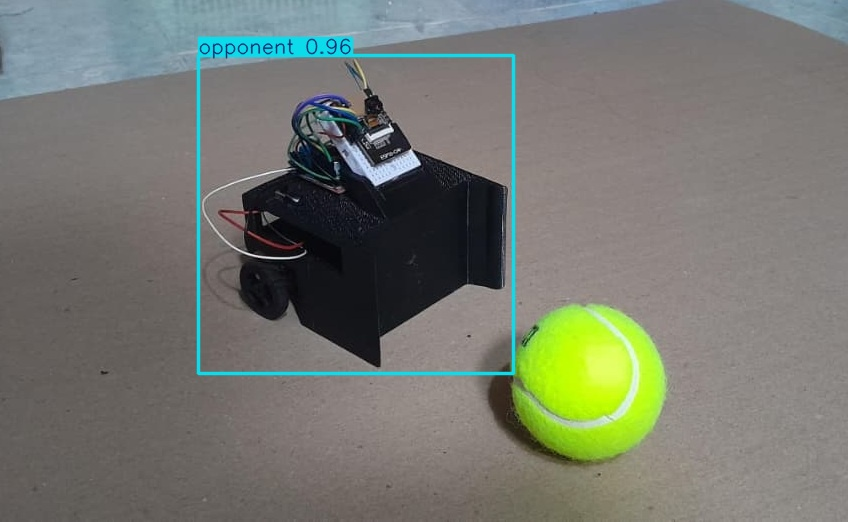

In [8]:
from ultralytics import YOLO
from PIL import Image

ensure_dir(RUNS)
model = YOLO(str(TARGET_WEIGHTS))

# --- Predict on IMAGES ---
images_dir = TESTDATA_DIR / "images"
img_save_dir = None
if images_dir.exists() and any(images_dir.iterdir()):
    log.info("[PREDICT] Images: %s", images_dir)
    res_img = model.predict(
        source=str(images_dir),
        save=True,
        conf=CONF_THRESH,
        device=device,
        project=str(RUNS),
        name="demo_images",
        exist_ok=True
    )
    img_save_dir = Path(res_img[0].save_dir) if isinstance(res_img, list) else Path(res_img.save_dir)
    log.info("[OK] Image predictions -> %s", img_save_dir)
else:
    log.info("[SKIP] No images/ folder found at %s", images_dir)

# --- Predict on VIDEOS ---
videos_dir = TESTDATA_DIR / "videos"
vid_save_dir = None
if videos_dir.exists() and any(videos_dir.iterdir()):
    log.info("[PREDICT] Videos: %s", videos_dir)
    res_vid = model.predict(
        source=str(videos_dir),
        save=True,
        conf=CONF_THRESH,
        device=device,
        project=str(RUNS),
        name="demo_videos",
        exist_ok=True
    )
    vid_save_dir = Path(res_vid[0].save_dir) if isinstance(res_vid, list) else Path(res_vid.save_dir)
    log.info("[OK] Video predictions -> %s", vid_save_dir)
else:
    log.info("[SKIP] No videos/ folder found at %s", videos_dir)

# --- Preview a small grid of predicted IMAGES ---
if img_save_dir and img_save_dir.exists():
    pred_imgs = sorted([p for p in img_save_dir.iterdir() if p.suffix.lower() in {".jpg",".jpeg",".png",".bmp"}])
    print(f"[PREVIEW] Showing up to 8 results from {img_save_dir} …")
    display_count = min(8, len(pred_imgs))
    if display_count == 0:
        print("[NOTE] No previewable images found in output.")
    else:
        # show in rows of 4
        for rstart in range(0, display_count, 4):
            row = pred_imgs[rstart:rstart+4]
            display(*(Image.open(p).convert("RGB") for p in row))
else:
    print("[NOTE] No image predictions to preview.")


### What’s next?

- Check the outputs:
  - Images: `soccer_vision/runs/demo_images/`
  - Videos: `soccer_vision/runs/demo_videos/`
- Tweak the confidence threshold in the **Config** cell:
  - `CONF_THRESH = 0.25` → increase to reduce false positives, decrease to get more detections.
- Want to test custom files?
  - Drop images or videos into `soccer_vision/test_data/images/` or `soccer_vision/test_data/videos/` and re-run the inference cell.
